# Atlas-level integration

In this tutorial, I will cover some tips and tricks for modeling large collections of single-cells using a scATAC-seq dataset of brain development produced by 10X genomics. 

One key problem when working with large-scale atlases is it can be hard to know how many topics will best represent the dataset - complex systems could require many tens of topics to capture all of the apparaent heterogeneity. Even though we provide an automated method for determining this, Bayesian search of extremely large ranges is time consuming and inefficient. In this tutorial, I demonstrate how to use gradient descent to estimate the number of topics in a dataset using a Dirichlet Process model.

## Preprocessing ATAC-seq data

The previous tutorial outlined some best practices for preprocessing scRNA-seq data and selecting genes to model. For scATAC-seq, preprocessing is somewhat less straightforward. The basic pipeline we recommend follows closely with that employed by 10X genomics:

1. align ATAC-seq fragments
2. Generate fragment file
3. Call peaks from fragment file
4. Intersect fragments with peaks to generate sparse, near-binary count matrix of size Ncells x Npeaks
5. Filter extremely rare peaks (<~30 cells), and non-cell droplets.

The 10x pipeline employs an in-house peak caller which does okay. If possible, we recommend re-calling peaks with MACs and re-aggregating fragments. Since highly-variable *peaks* are hard to identify due to the sparsity of the data, we recommend using all called peaks that are accessible in some reasonable number of cells as features (for example, more than 30 cells). 

First, import some packages:

In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import mira

Since we're training an accessibility model in this tutorial, we want to make sure we are working on a GPU:

In [22]:
assert torch.cuda.is_available()

Now, load some data:

In [23]:
mira.datasets.MouseBrainDataset()
data = anndata.read_h5ad('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_dataset.ad')
data = data[:, data.var.feature_types == 'Peaks']

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/e18_10X_brain_dataset
		* e18_mouse_brain_10x_dataset.ad
		* e18_mouse_brain_10x_main_barcodes.csv
		* e18_mouse_brain_10x_rna_model.pth
		* e18_mouse_brain_10x_atac_model.pth


First, filter out very rare peaks:

In [24]:
sc.pp.filter_genes(data, min_cells = 30)

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning:

Trying to modify attribute `.var` of view, initializing view as actual.



Next run some QC to filter invalid cells. Since this is a multiome dataset, we can filter out prospective cells which did not meet QC for gene expression:

In [25]:
barcodes = pd.read_csv('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_main_barcodes.csv',
                      names = ['index','barcode'], header=1)

data = data[barcodes.barcode]

This is followed by read count filtering. I set a minimal number of accessible peaks threshold at 1000:

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



[None, None]

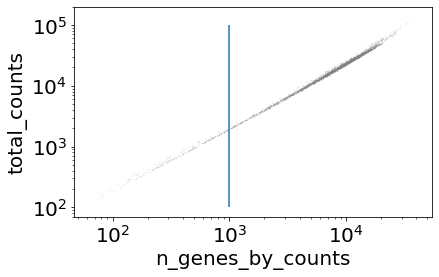

In [26]:
sc.pp.calculate_qc_metrics(data, inplace=True, log1p=False)

ax = sc.pl.scatter(data,
              x = 'n_genes_by_counts',
              y = 'total_counts',
              show = False,
              size = 1,
             )
ax.vlines(1000, 100, 1e5)
ax.set(xscale = 'log', yscale = 'log')

In [27]:
sc.pp.filter_cells(data, min_genes=1000)

As in the previous tutorial, we next instantiate a topic model. This time, make sure to flag `feature_type = "accessibility"`. Also, there are no batches so we need not flag any technical covariates. 

Finally, to reduce memory usage, one may choose to down-sample the number of peaks used for the encoder network of the model. Unless specified otherwise by `highly_variable_key`, all peaks in the Andata object will still be incorporated into topics. A good rule of thumb is to keep a minimum of 100K peaks as encoder features. If you have a favorite way of finding "informative" peaks, that may be employed instead of random down-sampling.

In [28]:
### Optional, alternatively, mark informative or highly variable peaks here
np.random.seed(0)
data.var['endogenous_peaks'] = np.random.rand(data.shape[1]) <= min(1e5/data.shape[1], 1)
###

model = mira.topics.make_model(
    *data.shape,
    feature_type = 'accessibility',
    endogenous_key='endogenous_peaks' # which peaks are used by the encoder network
)

## Caching data to disk

Now we arrive at the first tip for working with large datasets, which is to manually write training and testing chunks of cells to disk to reduce memory overhead:

In [29]:
!mkdir -p data/brain_tutorial
!rm -rf data/brain_tutorial/atac_train data/brain_tutorial/atac_test

train, test = model.train_test_split(data)

model.write_ondisk_dataset(train, dirname='data/brain_tutorial/atac_train')
model.write_ondisk_dataset(test, dirname='data/brain_tutorial/atac_test')

INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endogenous_peaks


Writing dataset to disk:   0%|          | 0/14 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endogenous_peaks


Writing dataset to disk:   0%|          | 0/4 [00:00<?, ?it/s]

This is handy because we can use the on-disk cache for training instead of keeping the potentially large dataset loaded in memory. Now continue as normal, but instead of supplying `anndata` objects to each method, you can pass a file location for some on-disk cache. Only small sections of the dataset are loaded while training from a cache. That way, you can train in environments with limited memory.

**Caching makes accessibility model training 2-3 times faster**

In [30]:
model.get_learning_rate_bounds('data/brain_tutorial/atac_train') # pass cache file

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (1.1321539638529521e-05, 0.2819539400400881)


(1.1321539638529521e-05, 0.2819539400400881)

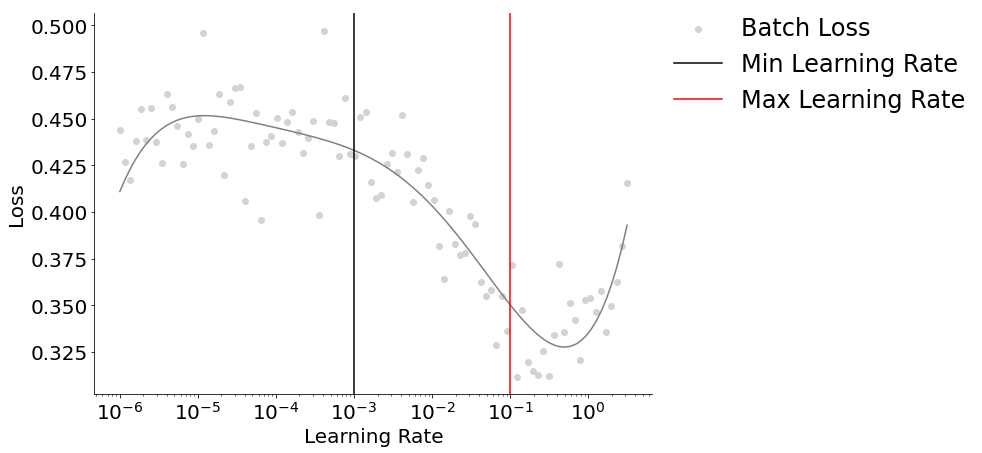

In [31]:
model.set_learning_rates(1e-3, 0.1)
ax = model.plot_learning_rate_bounds()

## Choosing num topics

Now, we must choose the number of topics to represent the dataset. As in the previous tutorial, we can start by using the `gradient_tune` method.

In [32]:
topic_contributions = mira.topics.gradient_tune(model, 'data/brain_tutorial/atac_train')

Training model:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting latent vars:   0%|          | 0/14 [00:00<?, ?it/s]

Then plot the maximum composition across cells that each topic was allocated. You may notice that while the gradient tuning model was instantiated with 50 topics available (a purposeful overshoot), only ~20 were actually allocated probability mass in the posterior (The elbow and a minimum threshold of 0.05 approximately coincide). Unfortunately, it is difficult to quantify uncertainty about this estimate, but hueristically, this dataset probably contains 20±(a few) topics.

<AxesSubplot:xlabel='Topic Number', ylabel='Max contribution'>

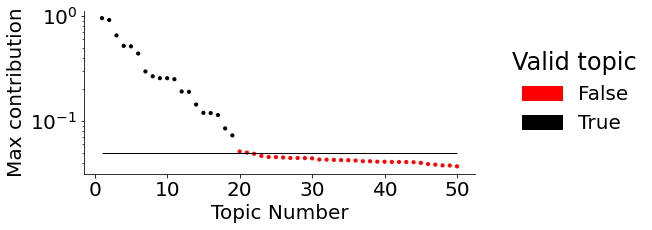

In [35]:
NUM_TOPICS = 19

mira.pl.plot_topic_contributions(topic_contributions, NUM_TOPICS, figsize = (7,3))

## (Optional) Refining the model using Bayesian optimization

Okay! That narrows it down quite a bit. You could continue to an analysis using this information by training a model like so:

```
model.set_params(num_topics = NUM_TOPICS).fit(data)
```

or you could refine the model further using the standard Bayesian hyperparameter optimization scheme. By setting the minimum and maxmimum bounds for `num_topics` comfortably around the previous estimate of 19, we can ensure we have selected the correct `num_topics` for the dataset.

### Notes on refinement

We used the Bayesian hyperparameter optimization scheme to select models for our benchmarking study. Though slower, this method yields the best models. The performance difference of models which have been refined versus those which are trained directly mostly comes down to tuning of regularization and trying different random initialization seeds. Both of these facets of the model are more influential for smaller dataset sizes. For this reason, we highly suggest refinement for datasets with <40K cells.

In [29]:
tuner = mira.topics.BayesianTuner(
    model = model,
    min_topics = NUM_TOPICS - 5,
    max_topics = NUM_TOPICS + 5,
    save_name = 'brain_tutorial/3',
    n_jobs=1
    # n_jobs = 5, # highly suggested - if you have the GPU memory!
    # storage = mira.topics.Redis(), # if you are running a redis server backend
)

Again, provide file locations for on-disk caches. This time, the tuner needs access to both the training and testing cache. Don't mix up the order!!!

**You can stop the tuner once it has converged - or at any time - using Ctrl-C (or Esc-I-I on Jupyter notebook).** Here, the best model was discovered on the third try, so I may have stopped tuning sooner.

In [ ]:
tuner.fit('data/brain_tutorial//atac_train', 'data/brain_tutorial/atac_test')

Trials finished: 36 | Best trial: 2 | Best score: 2.6711e+04
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/brain_tutorial/3
#Topics | #Trials 

     15 | ■ 
     17 | ■ 
     19 | ■ 
     20 | ■ ■ ■ ■ 
     21 | ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
     22 | ■ ■ ■ ■ ■ ■ ■ ■ ■ 
     23 | ■ ■ ■ ■ ■ ■ 
     24 | ■ 
     25 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   | ● | completed, score: 2.6717e+04 | {'decoder_dropout': 0.0634, 'num_topics': 17}
 #1   |   | completed, score: 2.6719e+04 | {'decoder_dropout': 0.0628, 'num_topics': 23}
 #2   | ● | completed, score: 2.6711e+04 | {'decoder_dropout': 0.0627, 'num_topics': 20}
 #3   |   | pruned at step: 8            | {'decoder_dropout': 0.0634, 'num_topics': 24}
 #4   |   | pruned at step: 8            | {'decoder_dropout': 0.0592, 'num_topics': 15}
 #5   |   | pruned at step: 16           | {'decoder_dropout': 0.0634, 'num_topics': 25}
 #6   |   | completed, score: 2.6724e+04 | {'decoder

Very nice! The Bayesian hyperparameter optimizer found that models with 20-23 topics performed best, while the very best model had 20 topics. We can load the best model like so:

In [19]:
model = tuner.fetch_best_weights()

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


The use it to produce the UMAP manifold of the dataset:

In [24]:
model.predict(data, box_cox = 0.25)

sc.pp.neighbors(data, use_rep='X_umap_features', metric='manhattan') 
sc.tl.umap(data, min_dist=0.1)

Predicting latent vars:   0%|          | 0/17 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


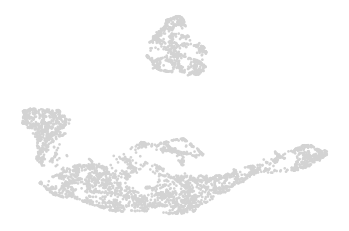

In [25]:
sc.pl.umap(data, frameon = False)